# Imports

In [1]:
# Common
import numpy as np
import pandas as pd

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Image Processing
import cv2
from PIL import Image

# Constants

In [2]:
CSV_PATH = '/kaggle/input/horse-riding-jumping-walking/640x360.csv'

# Utils

In [83]:
def plt_img(image, cmap="gray", flip_x_axis=False, flip_y_axis=False):
    """Display an image using matplotlib"""
    plt.imshow(image, cmap)
    if flip_y_axis:
        plt.gca().invert_yaxis() 
    if flip_x_axis:
        plt.gca().invert_xaxis() 
    plt.axis('on')
    plt.show()


def plt_frame_points(df_row):
    test_row = df_row
    x_min, y_min, x_max, y_max = test_row.bbox
    
    img = np.zeros((360, 640, 3), dtype=np.uint8)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=2)
    
    for col_name in test_row.index[2:-2]:
        r,g,b = parse_color(col_name)
        x, y = test_row[col_name]
        cv2.circle(img, (x, y), radius=5, color=(b,g,r), thickness=-1)
    
    plt_img(img)


# Function to safely convert a string to a list of integers
def parse_bbox(value):
    try:
        # Remove square brackets and split by spaces, then convert to integers
        return list(map(int, value.strip('[]').split()))
    except Exception as e:
        return []

def parse_color(column_name):
    # Split the string by underscores and convert each part to an integer
    try:
        return tuple(map(int, column_name.split('_')))
    except ValueError:
        return (0,0,0)

## Step1: Read data & Format

In [51]:
df = pd.read_csv(CSV_PATH)

# Sort Values w.r.t frames numbers
df = df.sort_values(by='frame_name', ascending=True)

# Format bbox & calculate area values
for idx, row in df.iterrows():
    # Parse the bounding box (assuming it is in the form 'x y w h')
    bbox = parse_bbox(row['bbox'])
    
    # Calculate the bounding box area (w * h)
    width = 0
    height = 0
    if len(bbox) > 0:
        x, y, w, h = bbox
        width = w
        height = h

    # Update the DataFrame
    df.at[idx, 'bbox'] = bbox
    df.at[idx, 'width'] = width 
    df.at[idx, 'height'] = height 

# Drop rows where the 'bbox' column contains an empty list
df = df[df['bbox'].apply(lambda x: x != [])]

# Change color column's type
for col in df.columns[2:-2]:
    df[col] = df[col].apply(
        lambda x: tuple(map(int, x.strip('()').split(','))) if pd.notnull(x) else None
    )

df.head()

,frame_name,bbox,255_128_0,255_153_51,255_178_102,230_230_0,255_153_255,153_204_255,255_102_255,255_51_255,...,255_51_51,153_255_153,102_255_102,51_255_51,0_255_0,0_0_255,255_0_0,255_255_255,width,height
9,66,"[96, 154, 229, 233]","(226, 156)","(225, 156)","(221, 154)","(218, 154)","(233, 163)","(214, 172)","(144, 176)","(206, 159)",...,"(187, 214)","(206, 212)","(134, 211)","(151, 210)","(183, 227)","(197, 222)","(134, 223)","(162, 224)",229.0,233.0
8,99,"[131, 149, 234, 230]","(227, 155)","(224, 160)","(216, 151)","(218, 153)","(233, 163)","(213, 173)","(141, 175)","(202, 164)",...,"(188, 213)","(211, 211)","(138, 206)","(155, 209)","(180, 226)","(201, 221)","(140, 225)","(166, 224)",234.0,230.0
88,132,"[130, 149, 236, 232]","(227, 153)","(222, 154)","(215, 150)","(216, 150)","(232, 162)","(214, 170)","(145, 174)","(200, 164)",...,"(192, 213)","(192, 215)","(159, 211)","(143, 208)","(208, 223)","(185, 226)","(171, 226)","(151, 227)",236.0,232.0
23,165,"[132, 148, 238, 232]",None,"(223, 158)",None,"(219, 153)","(228, 162)","(214, 170)","(144, 176)","(201, 162)",...,None,"(197, 212)","(161, 212)","(148, 210)","(215, 225)","(190, 221)","(171, 228)","(157, 228)",238.0,232.0
28,198,"[133, 148, 241, 235]",None,None,None,None,"(184, 180)","(212, 171)","(148, 175)","(196, 168)",...,"(219, 207)","(218, 209)","(153, 212)","(155, 213)","(224, 226)","(191, 219)","(165, 223)","(166, 229)",241.0,235.0


In [53]:
df.dtypes

frame_name       int64
bbox            object
255_128_0       object
255_153_51      object
255_178_102     object
230_230_0       object
255_153_255     object
153_204_255     object
255_102_255     object
255_51_255      object
102_178_255     object
51_153_255      object
255_153_153     object
255_102_102     object
255_51_51       object
153_255_153     object
102_255_102     object
51_255_51       object
0_255_0         object
0_0_255         object
255_0_0         object
255_255_255     object
width          float64
height         float64
dtype: object

## Step2: Shift Bounding Box & Its points to the origin

In [78]:
# Step 1: Make a copy of 'df' as 'shifted_df'
shifted_df = df.copy()

# Step 2: Loop through each row and perform the shifting operations
for idx, test_row in shifted_df.iterrows():
    # Extract the bounding box values
    x_min, y_min, x_max, y_max = test_row.bbox

    # Shift the rectangle to the image origin (0, 0)
    new_x_min = 0
    new_y_min = 0
    new_x_max = x_max - x_min
    new_y_max = y_max - y_min
    
    # Update the bounding box in shifted_df
    shifted_df.at[idx, 'bbox'] = (new_x_min, new_y_min, new_x_max, new_y_max)

    # Iterate through columns from index 2 to the second-to-last column (color columns)
    for col_name in test_row.index[2:-2]:
        # Parse the color column name to get RGB values
        r, g, b = parse_color(col_name)
        
        # If the column has pixel points (non-null)
        if pd.notnull(test_row[col_name]):
            x, y = test_row[col_name]  # Original coordinates
            
            # Shift the coordinates to the new bounding box origin
            updated_x, updated_y = (x - x_min, y - y_min)
            
            # Update the color column with the new coordinates (x, y)
            shifted_df.at[idx, col_name] = (updated_x, updated_y)

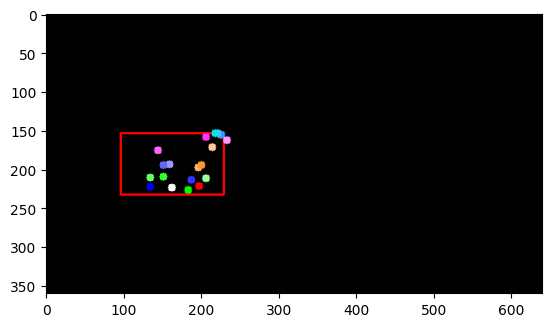

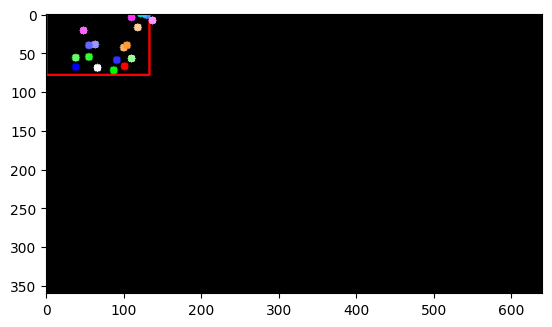

In [88]:
plt_frame_points(df.iloc[0])
plt_frame_points(shifted_df.iloc[0])

## Step3: Resize all points w.r.t to max bbox ratio

In [7]:
largest_width_row = df.loc[df['width'].idxmax()]
largest_height_row = df.loc[df['height'].idxmax()]

# print(largest_width_row)
# print(largest_height_row)